In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                               std=[0.20, 0.20, 0.20])                           
                       ]), download=True
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                               std=[0.20, 0.20, 0.20])                           
                       ]), download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    correct, total = 0, 0
    for X, y in loader:
        pred = model(X)
        indices = torch.argmax(pred, 1)
        correct += torch.sum(indices == y)
        total += y.shape[0]
        
    
    return float(correct) / total

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.842744, Train accuracy: 0.402092, Val accuracy: 0.551089
Average loss: 1.458145, Train accuracy: 0.587465, Val accuracy: 0.596273
Average loss: 1.379788, Train accuracy: 0.625960, Val accuracy: 0.636202


In [8]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3 * 32 * 32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.176041, Train accuracy: 0.197045, Val accuracy: 0.228517
Average loss: 2.032232, Train accuracy: 0.258642, Val accuracy: 0.295816
Average loss: 1.894601, Train accuracy: 0.323926, Val accuracy: 0.355402
Average loss: 1.795949, Train accuracy: 0.379756, Val accuracy: 0.402362
Average loss: 1.741339, Train accuracy: 0.406187, Val accuracy: 0.413419


In [9]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3 * 32 * 32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.041136, Train accuracy: 0.322185, Val accuracy: 0.439765
Average loss: 1.734783, Train accuracy: 0.483039, Val accuracy: 0.529384
Average loss: 1.617158, Train accuracy: 0.543050, Val accuracy: 0.554501
Average loss: 1.565807, Train accuracy: 0.566597, Val accuracy: 0.592519
Average loss: 1.529245, Train accuracy: 0.585008, Val accuracy: 0.599891


In [10]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3 * 32 * 32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.050453, Train accuracy: 0.317800, Val accuracy: 0.440653
Average loss: 1.758053, Train accuracy: 0.482271, Val accuracy: 0.540441
Average loss: 1.632622, Train accuracy: 0.550080, Val accuracy: 0.573271
Average loss: 1.572792, Train accuracy: 0.579036, Val accuracy: 0.595796
Average loss: 1.532838, Train accuracy: 0.599410, Val accuracy: 0.614429


In [0]:
class SubsetSampler(Sampler):
    """Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, sampler=sampler)

    predictions, ground_truth = [], []
    for X, y in loader:
        indices = torch.argmax(model(X), 1)
        predictions.append(indices)
        ground_truth.append(y)
        
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

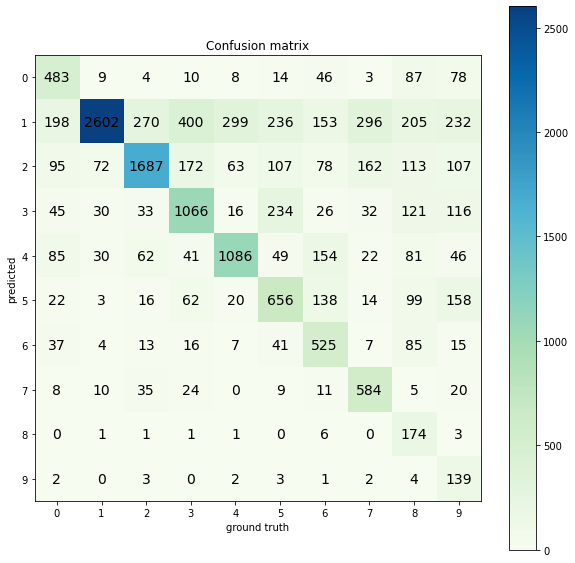

In [12]:
def visualize_confusion_matrix(confusion_matrix):
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10, 10), np.int)
    
    # TODO: Implement filling the prediction matrix
    for pred, gt in zip(predictions, ground_truth):
      confusion_matrix[pred][gt] += 1

    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [15]:
data_train_images = dset.SVHN('/content/gdrive/My Drive/DL_CSC/assignment2/data/', split='train', download=True)

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)

def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indices = val_indices[(predictions == predicted_class) & (groud_truth == gt_class)]
    visualize_images(indices, data, 'Predicted as the wrong class')

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

Using downloaded and verified file: /content/gdrive/My Drive/DL_CSC/assignment2/data/train_32x32.mat


<Figure size 720x108 with 0 Axes>

<Figure size 720x108 with 0 Axes>

In [19]:
import itertools

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size, gamma):    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

learning_rates = [1e-3, 1e-4]
ns_neurons = [100, 200]
weight_decays = [1e-3, 1e-4]
optimizers = [optim.SGD, optim.Adam, optim.RMSprop]
n_epochs = 25

best_classifier = None
best_optimizer = None
best_val_accuracy = None

for lr, n_neurons, weight_decay, nn_optimizer in itertools.product(learning_rates, 
                                                                ns_neurons, 
                                                                weight_decays,
                                                                optimizers):
    print(f'learning_rate={lr}, n_neurons={n_neurons}, weight_decay={weight_decay}, optimizer={nn_optimizer.__name__}')

    nn_models = [nn.Sequential(Flattener(),
                               nn.Linear(3 * 32 * 32, n_neurons),
                               nn.BatchNorm1d(n_neurons),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_neurons, 10),
                              ),
                 nn.Sequential(Flattener(),
                               nn.Linear(3 * 32 * 32, n_neurons),
                               nn.BatchNorm1d(n_neurons),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_neurons, n_neurons),
                               nn.BatchNorm1d(n_neurons),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_neurons, 10),
                              )
                ]

    for nn_model in nn_models:
        optimizer = nn_optimizer(nn_model.parameters(), lr=lr, weight_decay=weight_decay)
        _, _, val_hist = train_model(nn_model, train_loader, val_loader, loss, optimizer, n_epochs, 2, 0.5)
        accuracy = val_hist[-1]
        
        if not best_val_accuracy or accuracy > best_val_accuracy:
            best_classifier = nn_model
            best_optimizer = optimizer
            best_val_accuracy = accuracy

learning_rate=0.001, n_neurons=100, weight_decay=0.001, optimizer=SGD


KeyboardInterrupt: ignored

In [0]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)